In [221]:
import talib as ta
import numpy as np
import tushare as ts
import matplotlib.pyplot as plt
import pandas as pd
import os

In [222]:
pro = ts.pro_api(os.environ['TUSHARE_API_TOKEN'])

In [223]:
start = '20040101'                 # 回测起始时间
end = '20200801'                   # 回测结束时间
code = '000990.SH'                 # 回测标的代码

short_term = 11
long_term = 22

In [224]:
data = pro.index_daily(ts_code=code, start_date=start, end_date=end).sort_index(ascending=False)

In [225]:
close_price = np.array(data['close'])
open_price = np.array(data['open'])
time = np.array(data['trade_date'])
L=[time[i] for i in range(0,len(time),60)]

# 计算均线数值
short_ma = ta.MA(close_price, short_term)
long_ma = ta.MA(close_price, long_term)

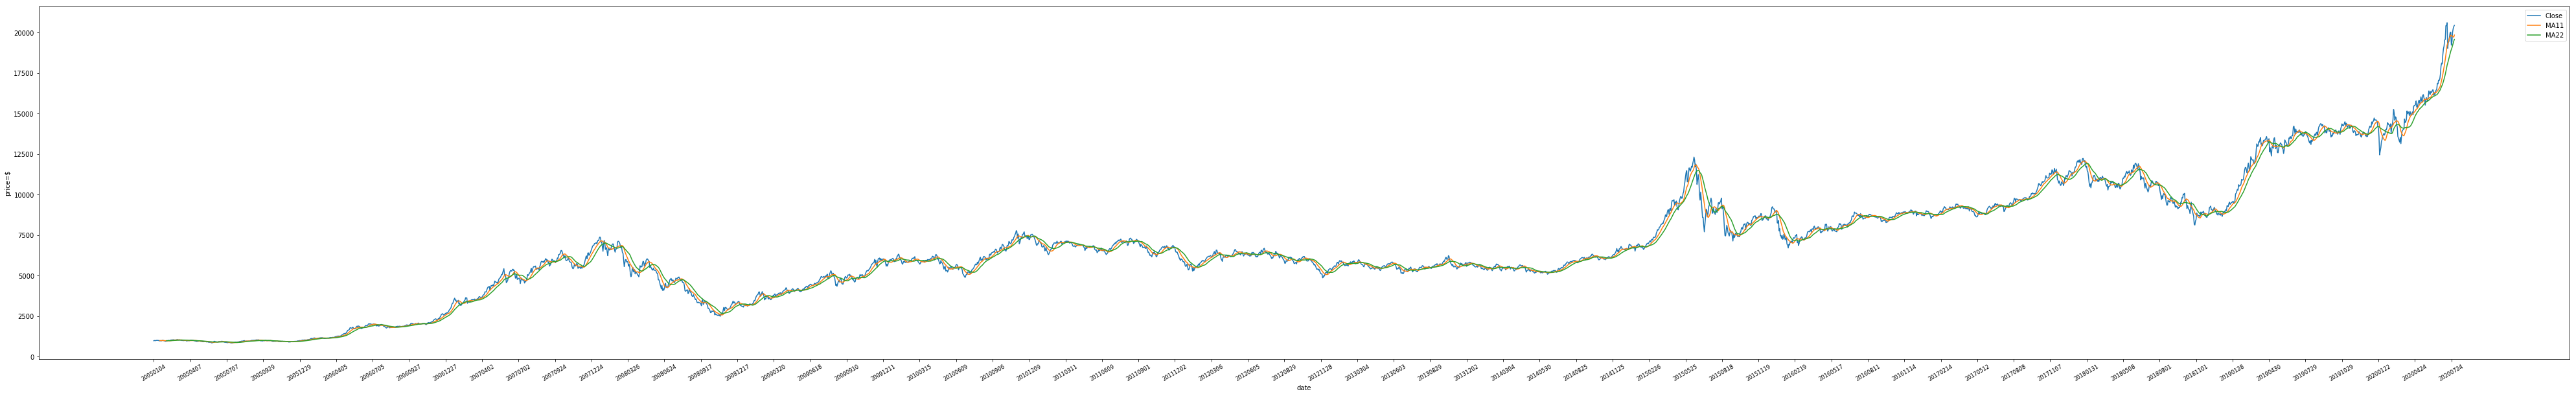

In [226]:
fig,ax=plt.subplots(figsize=(70,10))
ax.plot(time, close_price, label='Close')
ax.plot(time, short_ma, label='MA11')
ax.plot(time, long_ma, label='MA22')
ax.legend(loc='best')
ax.set_xticks(L)
ax.set_xlabel('date')
ax.set_ylabel('price=$')
plt.xticks(rotation=30,fontsize='small')
plt.show()

In [227]:
s = np.zeros(len(close_price))

is_hold = 0 # 0 - 空仓，1 - 买入，2 - 持仓，3 - 卖出

init_money = position_money = 1000000
position_amount = 0

trade_count = 0

buy_position_value = 0 # 每笔交易买入前总资金

for i in range(len(close_price)):
    trade_price = round((close_price[i] + open_price[i]) / 2, 2)
    if i == 0:
        s[0] = init_money
        continue
    if short_ma[i - 1] > long_ma[i - 1]: # 延迟一天，禁止使用未来函数
        if is_hold == 0: # 空仓买入
            is_hold = 1
            buy_position_value = position_money
            position_amount = int(position_money / trade_price)
            position_money = position_money - position_amount * trade_price
        elif is_hold == 1: # 买入持有
            is_hold = 2
        elif is_hold == 2: # 继续持有
            is_hold = 2
        elif is_hold == 3: # 卖出再次买入
            is_hold = 1
            buy_position_value = position_money
            position_amount = int(position_money / trade_price)
            position_money = position_money - position_amount * trade_price
    else:
        if is_hold == 0: # 空仓继续
            is_hold = 0
        elif is_hold == 1: # 买入卖出
            is_hold = 3
            position_money = position_money + position_amount * trade_price
            position_amount = 0
        elif is_hold == 2: # 持仓卖出
            is_hold = 3
            position_money = position_money + position_amount * trade_price
            position_amount = 0
        elif is_hold == 3: # 卖出空仓
            is_hold = 0
    
    s[i] = position_money + position_amount * close_price[i]
            
    if is_hold == 0:
        pass
    if is_hold == 1:
        print('日期: ' + str(time[i]) + ', 操作: 买入, 价格: ' + str(trade_price) + ', 持仓量: ' + str(position_amount) + ', 收盘后总资金: ' + str(round(s[i], 2)))
    if is_hold == 2:
        pass
    if is_hold == 3:
        print('日期: ' + str(time[i]) + ', 操作: 卖出, 价格: ' + str(trade_price) + ', 获利' + str(round(position_money - buy_position_value, 2)) + '(' + str(round((position_money - buy_position_value) / buy_position_value * 100, 2)) + '%)' + ', 收盘后总资金: ' + str(round(s[i], 2)))
        print('***************************************************************************************************')
        trade_count = trade_count + 1

print('###################################################################################################')
print("共交易" + str(trade_count) + "次")
print("双均线策略总收益率为: " + str(round((s[-1] - s[0]) / s[0] * 100, 2)) + '%')
print("基准(买入一直持有)的收益率为：" + str(round((close_price[-1] - close_price[0]) / close_price[0] * 100, 2)) + '%')

日期: 20050224, 操作: 买入, 价格: 1033.86, 持仓量: 967, 收盘后总资金: 1003311.98
日期: 20050323, 操作: 卖出, 价格: 992.58, 获利-39917.76(-3.99%), 收盘后总资金: 960082.24
***************************************************************************************************
日期: 20050415, 操作: 买入, 价格: 996.83, 持仓量: 963, 收盘后总资金: 954803.07
日期: 20050425, 操作: 卖出, 价格: 942.11, 获利-52695.36(-5.49%), 收盘后总资金: 907386.88
***************************************************************************************************
日期: 20050620, 操作: 买入, 价格: 922.42, 持仓量: 983, 收盘后总资金: 922756.09
日期: 20050707, 操作: 卖出, 价格: 879.05, 获利-42632.71(-4.7%), 收盘后总资金: 864754.17
***************************************************************************************************
日期: 20050803, 操作: 买入, 价格: 913.36, 持仓量: 946, 收盘后总资金: 866658.47
日期: 20050930, 操作: 卖出, 价格: 986.75, 获利69426.94(8.03%), 收盘后总资金: 934181.11
***************************************************************************************************
日期: 20051026, 操作: 买入, 价格: 977.1, 持仓量: 956, 收盘后总资金: 925861.04


In [228]:
base_15 = np.zeros(len(close_price))

for i in range(len(close_price)):
    if i == 0:
        base_15[i] = init_money
    else:
        base_15[i] = base_15[i-1] * 1.0005592 # 设年收益为0.15，250个交易日，则每日的收益率为0.0005592

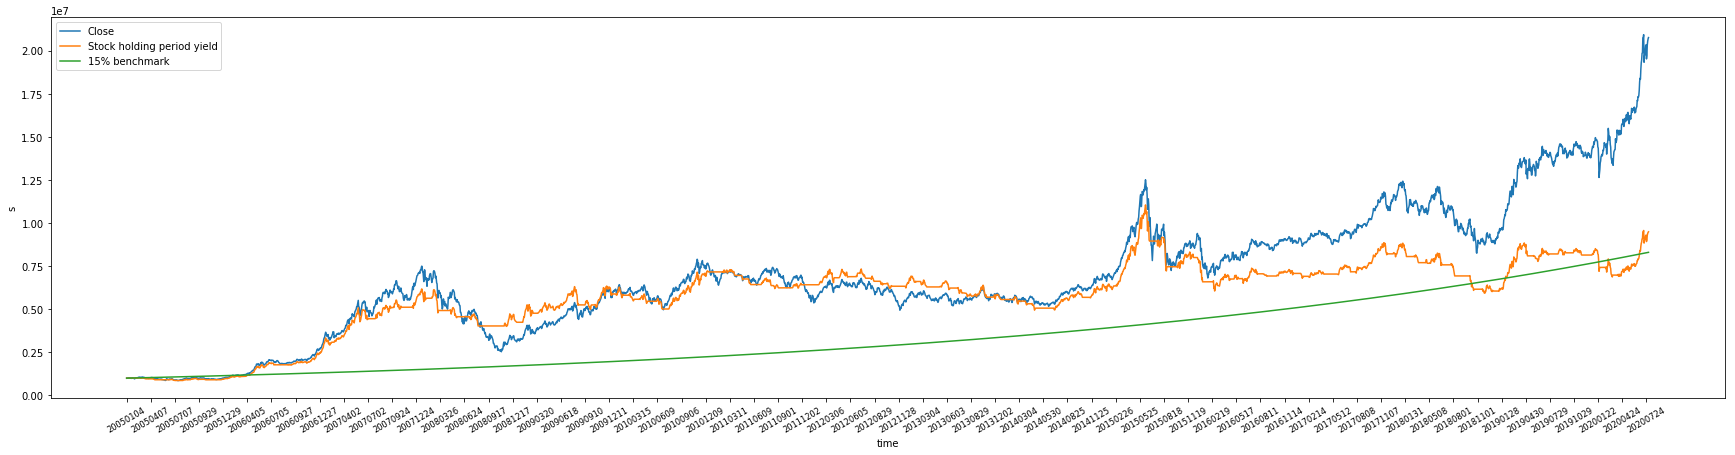

In [229]:
# 本资金模拟交易可能的影响因素：
# 1. 涨停跌停无法交易问题。指数很少有涨跌停，所以影响还可以接受。
# 2. 交易手续费。对指数ETF来说，交易少的情况下，手续费可以忽略。
# 3. 分红。除少数基金有分红，大部分分红可以忽略。
# 4. 交易滑点。才有当天开盘和收盘的平均价格来模拟滑点的影响。

fig=plt.figure(figsize=(30,7))
ax=fig.add_subplot(111)
k = s[0] / close_price[0]
ax.plot(time, close_price * k, label='Close')
ax.plot(time,s,label='Stock holding period yield')
ax.plot(time,base_15,label='15% benchmark')
ax.legend(loc='best')
ax.set_xlabel('time')
ax.set_ylabel('s')
ax.set_xticks(L)
plt.xticks(rotation=30,fontsize='small')
plt.show()

In [164]:
pro.index_weight(index_code='399300.SZ', start_date='20080901', end_date='20100930')

,index_code,con_code,trade_date,weight
0,399300.SZ,600109.SH,20100930,0.10
1,399300.SZ,600688.SH,20100930,0.17
2,399300.SZ,600100.SH,20100930,0.32
3,399300.SZ,601139.SH,20100930,0.06
4,399300.SZ,600009.SH,20100930,0.24
5,399300.SZ,601866.SH,20100930,0.18
6,399300.SZ,600863.SH,20100930,0.10
7,399300.SZ,601299.SH,20100930,0.36
8,399300.SZ,600598.SH,20100930,0.19
9,399300.SZ,601872.SH,20100930,0.13


1. PE

PE（Price earnings ratio，即 P/E ratio）也就是“市价盈利比率”，简称“市盈率”，常被用来评估股价水平是否合理。通俗点说，在公司盈利能力不变的情况下，PE代表了买下一个公司需要多少年就可以回本。通常股票PE的计算方法是：

PE = 股价 / 每股盈利

或者

PE = (股价 * 股本数) / (每股盈利 * 股本数) = 市值 / 公司净利润


只需要阅读公司财报，知道去年公司的总股本、净利润，以及当前的股价就可以计算上市公司的PE。但是我们经常提到的指数PE怎样计算？


指数由多家公司通过一定的加权规则编制而成，指数PE代表了按照公司权重买下这个指数中的所有公司后，需要多少年回本。假设一个指数中有n个公司，第i个公司的权重为Wi，PE为PEi，那么指数PE的计算方法是：

指数PE = 1 / sum(Wi/PEi)


看起来公式很简单，只需要 Wi 和 PEi 就可以了对不对？实际上会遇到什么问题呢？


通常情况下我们从指数公司官网能知道指数的编制方式，但是在指数编制规则中会加入各种各样的特殊处理和限制条件，所以你无法从指数编制方法中得到准确的指数权重信息。指数权重数据属于指数编制的核心信息，通常需要向指数公司付费才能得知。严格意义上来说，没有准确的指数权重数据，我们无法计算准确的指数PE。但是如果你付不起这个费用该怎么办？用以下方法近似求解：

市值加权
市值加权是目前A股指数中最常见的一种加权方式，市值加权的指数可以不用准确的指数权重数据，直接采用市值加权的方式近似计算。假设指数中第i个公司的市值为Mi，净利润为Ei，市值加权指数PE计算方法是：

指数PE = sum(Mi) / sum(Ei)

是不是一下就简单了好多？

2. 等权计算

等权指数也就是指数中每个样本股所占的权重相同，实际操作中，等权指数并不会每天保持样本股权重相同，还会定期调整权重，但是依然可以用等权方法近似计算。假设指数中共有n个公司，其中第i个公司的PE为PEi，等权指数PE计算方法为：
指数PE = n / sum(1/PEi)
是不是也简单很多？


3. 因子加权

一些指数在编制方案中采用风格因子加权，比如股息率、波动率等因子。这些因子的具体数据很难查到，不妨用上面讲的市值加权或者等权计算方法来近似计算，但是计算结果的可信度会稍差一些。

最后提醒：即使简单的计算方法也需要有准确的基础数据才能保证计算结果准确，而上面公式中提到的基础数据有各种各样的坑需要处理。如果有人想尝试自己计算指数PE，务必小心谨慎一些。